In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from IPython.display import display

from astropy.io import ascii
from astropy.table import Table, Column

%matplotlib inline

In [2]:
cat = ascii.read('cat_lau.csv')

In [3]:
cat['J-Ks'] = cat['J$_{2\\prime\\prime}$'] - cat['Ks$_{2\\prime\\prime}$']
cat['H-Ks'] = cat['H$_{2\\prime\\prime}$'] - cat['Ks$_{2\\prime\\prime}$']
cat['J-H'] = cat['J$_{2\\prime\\prime}$'] - cat['H$_{2\\prime\\prime}$']

In [4]:
vis = cat[cat['Visual']=='True']

In [5]:
d010 = ascii.read('d010_resto.dat', format='ipac')
d115 = ascii.read('d115_resto.dat', format='ipac')

In [25]:
gxs = vis[['J', 'H', 'Ks', 'J-Ks', 'J-H', 'H-Ks', 'R$_{1/2}$', 'C', '$\\epsilon$', 'n']].to_pandas()

In [26]:
d010['J-Ks'] = d010['MAG_APER_J_C'] - d010['MAG_APER_Ks_C']
d010['H-Ks'] = d010['MAG_APER_H_C'] - d010['MAG_APER_Ks_C']
d010['J-H'] = d010['MAG_APER_J_C'] - d010['MAG_APER_H_C']
d115['J-Ks'] = d115['MAG_APER_J_C'] - d115['MAG_APER_Ks_C']
d115['H-Ks'] = d115['MAG_APER_H_C'] - d115['MAG_APER_Ks_C']
d115['J-H'] = d115['MAG_APER_J_C'] - d115['MAG_APER_H_C']

In [27]:
strs_d010= d010[['MAG_PSF_J_C','MAG_PSF_H_C','MAG_PSF_Ks_C', 'J-Ks', 'J-H', 'H-Ks',
            'FLUX_RADIUS_051','C','ELLIPTICITY','SPHEROID_SERSICN']].to_pandas()

In [28]:
strs_d115= d115[['MAG_PSF_J_C','MAG_PSF_H_C','MAG_PSF_Ks_C', 'J-Ks', 'J-H', 'H-Ks',
                 'FLUX_RADIUS_051','C','ELLIPTICITY','SPHEROID_SERSICN']].to_pandas()

In [303]:
strs = pd.concat([strs_d010, strs_d115])
strs.to_csv('stars_corrected.csv')

In [30]:
strs = strs[strs.MAG_PSF_J_C < 30]
gxs = gxs[gxs.J<30]

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn import neighbors
import sklearn.cross_validation as cv
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

In [158]:
def experiment(clf, x, y, nfolds=10):
    skf = StratifiedKFold(n_splits=nfolds)
    probabilities = np.array([])
    predictions = np.array([])
    y_testing = np.array([])
    
    for train, test in skf.split(x, y):
        
        x_train = x[train]
        y_train = y[train]
        clf.fit(x_train, y_train)

        x_test = x[test]
        y_test = y[test]
        pr = clf.predict(x_test)
        probs = clf.predict_proba(x_test)[:, 0]

        probabilities = np.hstack([probabilities, probs])
        predictions = np.hstack([predictions, pr])
        y_testing = np.hstack([y_testing, y_test])

    print metrics.classification_report(y_testing, predictions)
    fpr, tpr, thresholds = metrics.roc_curve(y_testing, 1.-probabilities)
    pr_rec_curve = metrics.precision_recall_curve(y_testing, 1.-probabilities)
    roc_auc = metrics.auc(fpr, tpr)
    return {'fpr': fpr, 
            'tpr': tpr, 
            'thresh': thresholds, 
            'roc_auc': roc_auc, 
            'brier_loss': metrics.brier_score_loss(y_testing, 1.-probabilities),
            'pr_rec_curve': pr_rec_curve,
            'y_test': y_testing, 
            'predictions': predictions,
            'probabilities': probabilities, 
            'confusion_matrix': metrics.confusion_matrix(y_testing, predictions),
            }

In [304]:
strs2 = strs.sample(1000)

In [305]:
X = np.vstack((strs2.as_matrix(), gxs.as_matrix()))
Y = np.hstack((np.repeat(0, len(strs2)), np.repeat(1, len(gxs))))

### Decision Tree (gini)

In [306]:
res_Dtree = experiment(DecisionTreeClassifier(max_leaf_nodes=12), X, Y, 10)

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00      1000
        1.0       0.96      0.94      0.95        90

avg / total       0.99      0.99      0.99      1090



### K-Neirest Neighbors

In [307]:
res_knn = experiment(neighbors.KNeighborsClassifier(n_neighbors=3, weights='uniform'), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99      1000
        1.0       0.89      0.88      0.88        90

avg / total       0.98      0.98      0.98      1090



### Support Vector Machines

In [308]:
res_svc = experiment(svm.SVC(kernel='linear', probability=True), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.99      0.98      0.98      1000
        1.0       0.83      0.84      0.84        90

avg / total       0.97      0.97      0.97      1090



## Random Forest

In [309]:
res_Rforest = experiment(RandomForestClassifier(n_estimators=300, 
                                                max_features=8, 
                                                min_samples_leaf=20,
                                                n_jobs=8), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99      1000
        1.0       0.91      0.77      0.83        90

avg / total       0.97      0.97      0.97      1090



### C45

In [310]:
res_C45 = experiment(DecisionTreeClassifier(criterion='entropy', min_samples_leaf=15), X, Y, 10)

             precision    recall  f1-score   support

        0.0       0.98      0.99      0.99      1000
        1.0       0.89      0.78      0.83        90

avg / total       0.97      0.97      0.97      1090



### ROC Curve

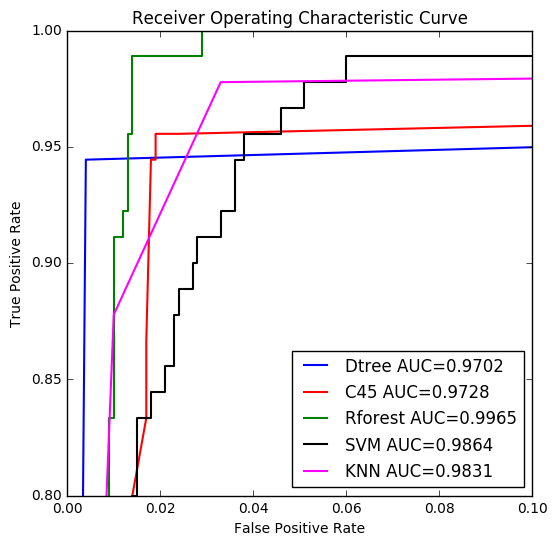

In [315]:
plt.figure(figsize=(6, 6))
#plt.figaspect(.8)

fpr = res_Dtree['fpr']
tpr = res_Dtree['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(roc_auc))

fpr = res_C45['fpr']
tpr = res_C45['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(roc_auc))

fpr = res_Rforest['fpr']
tpr = res_Rforest['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(roc_auc))

fpr = res_svc['fpr']
tpr = res_svc['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(roc_auc))

fpr = res_knn['fpr']
tpr = res_knn['tpr']
roc_auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(roc_auc))

plt.xlim(0, 0.1)
plt.ylim(0.8, 1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.title('Receiver Operating Characteristic Curve')

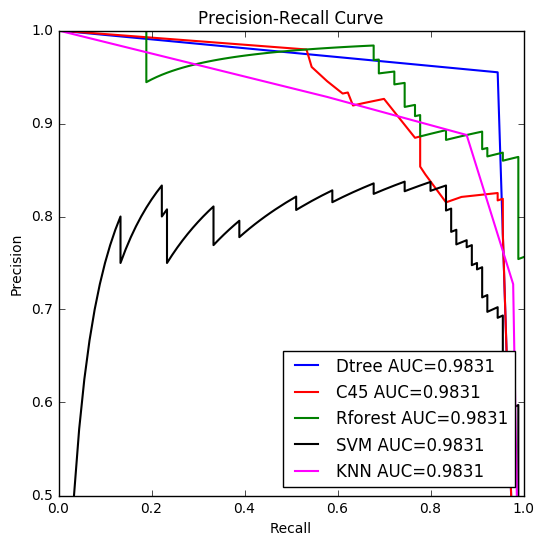

In [314]:
plt.figure(figsize=(6, 6))
#plt.figaspect(.8)

pr, rec, thr = res_Dtree['pr_rec_curve']
plt.plot(rec, pr, lw=1.5, color='blue', label='Dtree AUC={:06.4f}'.format(roc_auc))

pr, rec, thr = res_C45['pr_rec_curve']
plt.plot(rec, pr, lw=1.5, color='red', label='C45 AUC={:06.4f}'.format(roc_auc))

pr, rec, thr = res_Rforest['pr_rec_curve']
plt.plot(rec, pr, lw=1.5, color='green', label='Rforest AUC={:06.4f}'.format(roc_auc))

pr, rec, thr = res_svc['pr_rec_curve']
plt.plot(rec, pr, lw=1.5, color='black', label='SVM AUC={:06.4f}'.format(roc_auc))

pr, rec, thr = res_knn['pr_rec_curve']
plt.plot(rec, pr, lw=1.5, color='magenta', label='KNN AUC={:06.4f}'.format(roc_auc))

#plt.xlim(0, 0.2)
plt.ylim(0.5, 1)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.title('Precision-Recall Curve')

Confusion matrix, without normalization
[[ 1.     0.858  0.794  0.826  0.715  0.814]
 [ 0.858  1.     0.865  0.823  0.777  0.945]
 [ 0.794  0.865  1.     0.797  0.825  0.872]
 [ 0.826  0.823  0.797  1.     0.781  0.818]
 [ 0.715  0.777  0.825  0.781  1.     0.82 ]
 [ 0.814  0.945  0.872  0.818  0.82   1.   ]]


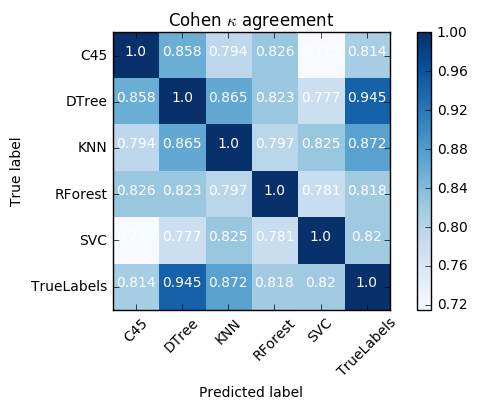

In [313]:
# methods = {'C45'    : res_C45, 
#            'DTree'  : res_Dtree,
#            'KNN'    : res_knn, 
#            'RForest': res_Rforest, 
#            'SVC'    : res_svc}
true_labels = {'predictions': res_svc['y_test']}

methods = [res_C45, res_Dtree, res_knn, res_Rforest, res_svc, true_labels]

kappa_agreement = np.empty((len(methods), len(methods)))

for i in range(len(methods)):
    for j in range(len(methods)):
        kappa_agreement[i, j] = metrics.cohen_kappa_score(methods[i]['predictions'],
                                                          methods[j]['predictions'])#, 
                                                          #labels=['star', 'galaxy'])

plot_confusion_matrix(np.round(kappa_agreement, 3), 
                      classes=['C45', 'DTree', 'KNN', 'RForest', 'SVC', 'TrueLabels'],
                      title=r'Cohen $\kappa$ agreement')

## Testing vs non-visual galaxies

In [316]:
no_vis = cat[cat['Visual']=='False']

In [317]:
gxs_no_vis = no_vis[['J', 'H', 'Ks', 'J-Ks', 'J-H', 'H-Ks', 'R$_{1/2}$', 'C', '$\\epsilon$', 'n']].to_pandas()

gxs_no_vis.dropna(inplace=True)

In [318]:
strs2 = strs#.sample(5000)

In [319]:
X_test = np.vstack((strs2.as_matrix(), gxs_no_vis.as_matrix()))

Y_test = np.hstack((np.repeat(0, len(strs2)), np.repeat(1, len(gxs_no_vis))))

In [320]:
rforest = RandomForestClassifier(n_estimators=300, max_features=8, min_samples_leaf=20, n_jobs=8)
rforest.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=8, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=300, n_jobs=8, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [321]:
y_proba = rforest.predict_proba(X_test)[:,0]
y_predict  = rforest.predict(X_test)

print metrics.classification_report(Y_test, y_predict)

             precision    recall  f1-score   support

          0       0.99      0.99      0.99     40000
          1       0.38      0.38      0.38       482

avg / total       0.99      0.99      0.99     40482



In [322]:
pr, rec, thr = metrics.precision_recall_curve(Y_test, 1.-y_proba)
fpr, tpr, thr = metrics.roc_curve(Y_test, 1.-y_proba)

In [323]:
print "Brier-loss score = {}".format(metrics.brier_score_loss(Y_test, 1.-y_proba))

Brier-loss score = 0.0108851263182


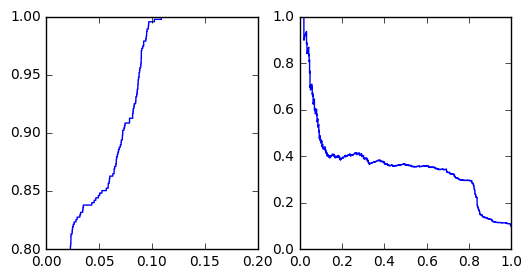

In [324]:
plt.figure(figsize=(6, 3))
plt.subplot(121)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1.)
plt.plot(fpr, tpr)
plt.subplot(122)
plt.plot(rec, pr)

In [325]:
print metrics.confusion_matrix(Y_test, y_predict)

[[39708   292]
 [  300   182]]


In [326]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[39708   292]
 [  300   182]]


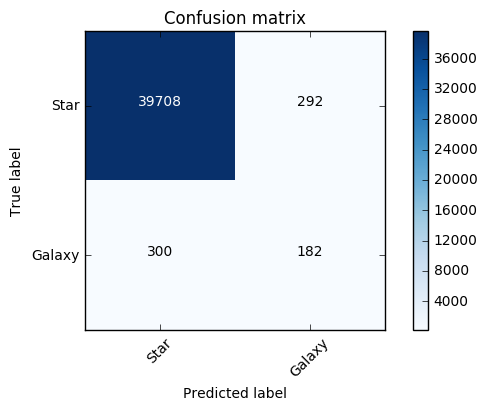

In [327]:
plot_confusion_matrix(metrics.confusion_matrix(Y_test, y_predict), ['Star', 'Galaxy'], normalize=False)